In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

In [2]:
from graphviz import Digraph

def trace(root):
    '''
    Build a set of all nodes and edges in a graph,
    the order does not matter
    '''
    nodes, edges = set(), set()
    
    def build(v): # a heuristic topological sort function
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # define edge like this
                build(child)

    build(root)
    return nodes, edges

# first have an scheme of your desired graph based on the nodes and operations
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR : left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record') node for it
        # a visual node
        dot.node(name=uid, label=f'{n.label} | data: {n.data} | grad: {n.grad}', shape='record')
        if n._op:
            # if this value is result of some operation, create an operation node for it
            dot.node(name=uid+n._op , label=n._op) # n._op is a string
            # and connect the op node to the value node
            dot.edge(uid+n._op , uid)
            for child in n._prev:
                dot.edge( str(id(child)) , uid+n._op)
    return dot

## Engine file changes

### 1- Let's make add & mul with numbers possible:
like x1 + 2.0 or 2 * x1
since they are not the same object type, we can't add them!

let's modify the code then:

1) x1 + 2.0 is actually x1.__add__(2.0)
so we need to modify this method

2) but 2 * x1 is actually 2.__mul__(x1) !!
we need to define x1.__rmul__(self)
which is a fallback, if python can't solve 2 * x1 it checks if it can solve x1 * 2 and that would call x1.__rmul__ :)

### 2- divison , power
a /b = a * b**-1

### 3- subtraction, negation

### 4- relu

In [3]:
class Value:
    
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self._prev = set(_prev) # the order does not matter, use set instead of list
        self._op = _op
        self.label = label

        self.grad = 0.0

        # After the forwrd path (when we have the data vlaue of all nodes)
        # we start the backprop (to get the gradients for each node)
        # the output node of each operation knows the operation and children
        # since we dont have a backprop for leaf nodes, and 
        # each operation has different local gradient
        # we can't define a general method in the class.
        # so at the time of doing the operation,
        # we can both define the local gradiant function
        # and store the whole chain rule function in an attribute to call later.
        # then call the local this function attribute from end node to the begining.
        self._backprop = lambda: None
    
    def __repr__(self) -> str:
        return f'Value({self.label}:{self.data})'
    
    def __add__(self, other):
        # check if 'other' is an instance of 'Value'
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += out.grad
            other.grad += out.grad

        out._backprop = _backprop
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + -1*other
    
    def __rsub__(self, other):
        return -1*(self + -1*other)
    
    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        # check if 'other' is an instance of 'Value'
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), _op='*')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1
    
    def __pow__(self, other):
        # only support int or float powers for now!!
        # in case of other of type 'Value', we would need another method
        assert isinstance(other, (int, float))
        
        out = Value(self.data**other, (self,), _op=f'**{other}')

        def _backprop():
            self.grad += (other * self.data**(other - 1)) * out.grad
        
        out._backprop = _backprop
        return out

    def relu(self):
        out = Value( self.data if self.data > 0.0 else 0.0 , (self,), _op='ReLU' )
        
        def _backprop():
            self.grad += out.grad * (out.data > 0.0)
        
        out._backprop = _backprop
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), _op='exp')
        
        def _backprop():
            self.grad += out.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) + 1)
        out = Value( tanh, (self,), _op='tanh')
        
        def _backprop():
            self.grad += (1 - tanh**2) * out.grad
        
        out._backprop = _backprop
        return out
    
    def backprop(self):
        topo_sort_list = []
        visited = set() # the order does not matter, use set instead of list
        
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                # Appending to topo_sort before its children are processed
                # will give us out-to-left sort,
                # but not out to leaf sort in case of b (bias leaf), try it & see it
                for child in root._prev:
                    build_topo(child)
                # Appending after its children are processed
                # will give us leaf-to-out sort
                topo_sort_list.append(root)
        
        build_topo(root=self)
        
        self.grad = 1.0
        for node in reversed(topo_sort_list):
            node._backprop()


In [25]:
a = Value(2.0)
b = Value(3.0)
a / b

Value(:0.6666666666666666)

## NN architecture file changes

### 1) let's break up tanh to a bunch of expressions based exp
(np.exp(2*self.data) - 1)/(np.exp(2*self.data) + 1)

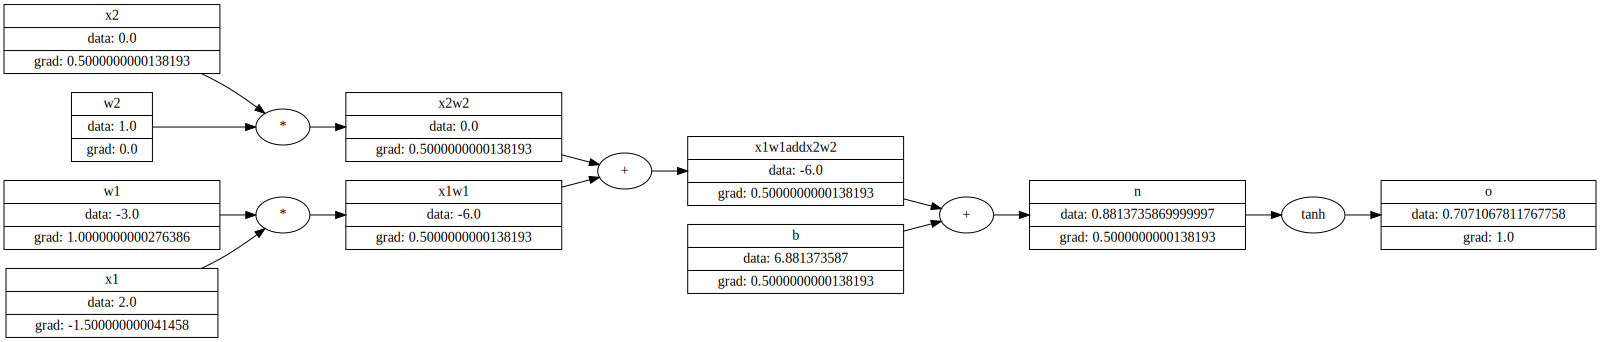

In [53]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of Neuron
b = Value(6.881373587, label='b')

# we do the multiplication one-by-one
# so that we have the pointers to all intermediate values

x1w1 = x1*w1;               x1w1.label = 'x1w1'
x2w2 = x2*w2;               x2w2.label = 'x2w2'

x1w1addx2w2 = x1w1 + x2w2;  x1w1addx2w2.label = 'x1w1addx2w2'
n = x1w1addx2w2 + b;        n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backprop()
draw_dot(o)

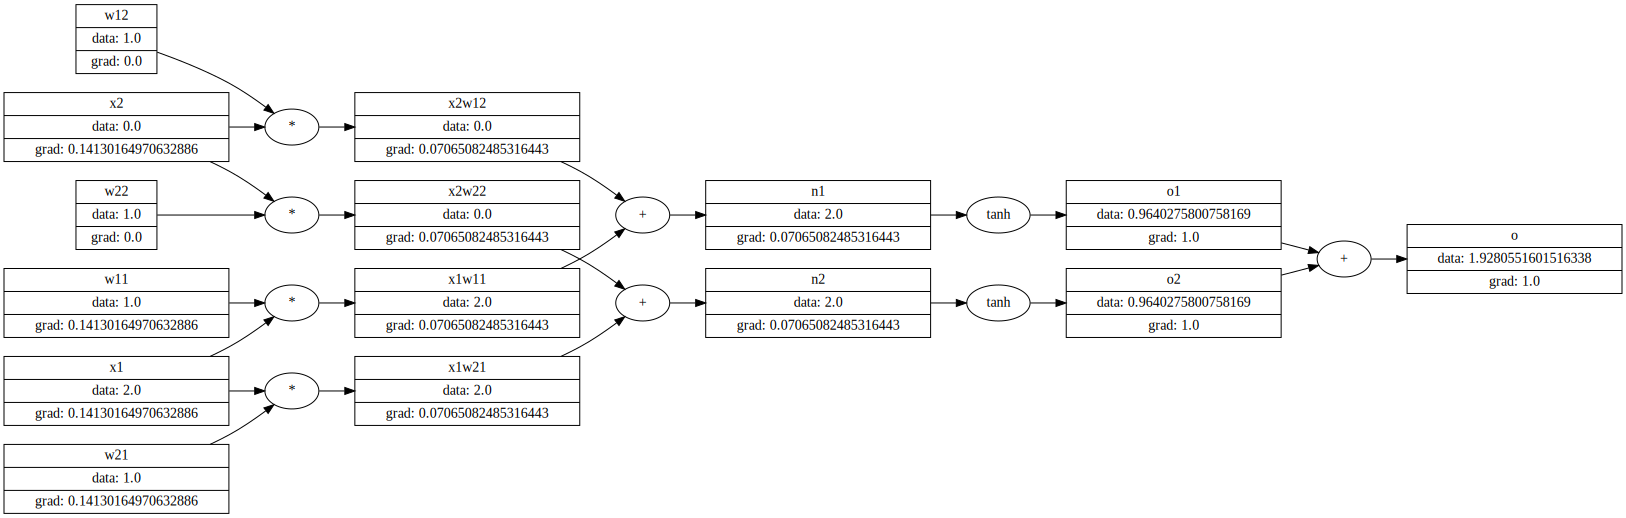

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w11 = Value(1.0, label='w11')
w12 = Value(1.0, label='w12')
# bias of Neuron
# b = Value(6.881373587, label='b1')

w21 = Value(1.0, label='w21')
w22 = Value(1.0, label='w22')
# bias of Neuron
# b = Value(6.881373587, label='b2')

# we do the multiplication one-by-one
# so that we have the pointers to all intermediate values

x1w11 = x1*w11;               x1w11.label = 'x1w11'
x2w12 = x2*w12;               x2w12.label = 'x2w12'
n1 = x1w11 + x2w12;           n1.label = 'n1'
o1 = n1.tanh()   ;             o1.label = 'o1'

x1w21 = x1*w21;               x1w21.label = 'x1w21'
x2w22 = x2*w22;               x2w22.label = 'x2w22'
n2 = x1w21 + x2w22;           n2.label = 'n2'
o2 = n2.tanh();                o2.label = 'o2'

# e = (2*n).exp();            e.label = 'e'
# o = (e - 1.0)/(e + 1.0) 

o = o1 + o2
o.label = 'o'
o.backprop()
draw_dot(o)